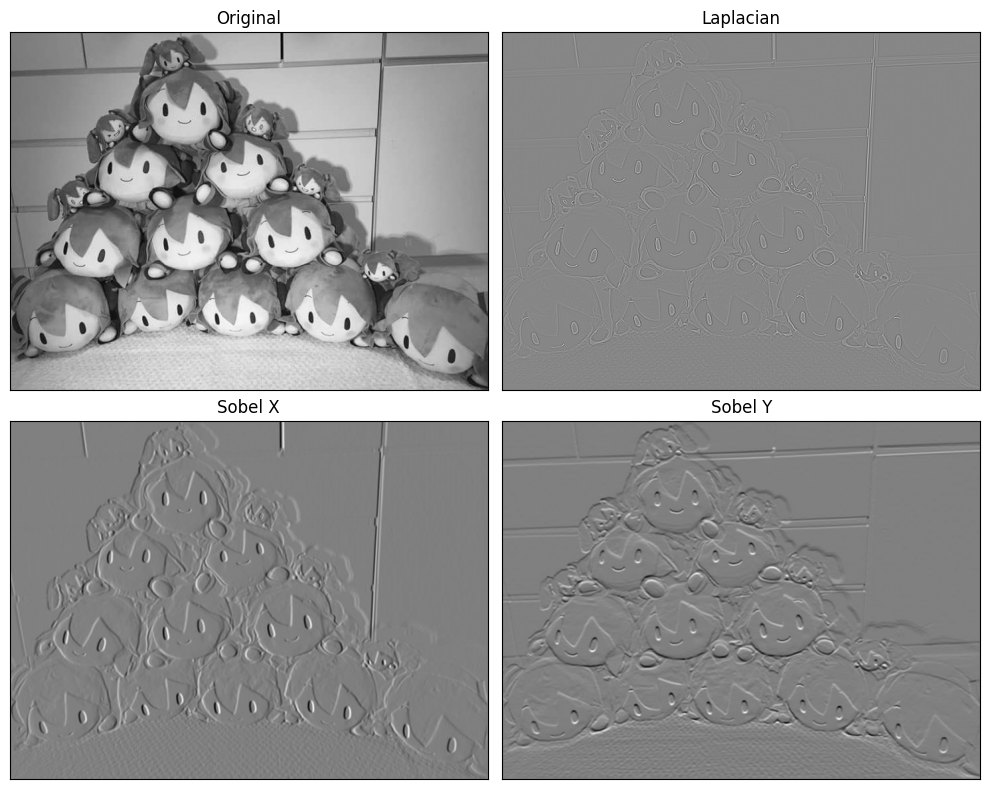

In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

# Read the image in grayscale
img = cv.imread('hatsune.jpg', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('Okarun.jpeg', cv.IMREAD_GRAYSCALE)
img3 = cv.imread('meme.jpeg', cv.IMREAD_GRAYSCALE)
img4 = cv.imread('memeGirl.jpg', cv.IMREAD_GRAYSCALE)
img5 = cv.imread('memeKid.jpg', cv.IMREAD_GRAYSCALE)

assert img is not None, "file could not be read, check with os.path.exists()"

# Apply Laplacian and Sobel filters
laplacian = cv.Laplacian(img, cv.CV_64F)
sobelx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=5)
sobely = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=5)

# Display the results
plt.figure(figsize=(10, 8))
plt.subplot(2,2,1), plt.imshow(img, cmap='gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2), plt.imshow(laplacian, cmap='gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3), plt.imshow(sobelx, cmap='gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4), plt.imshow(sobely, cmap='gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()


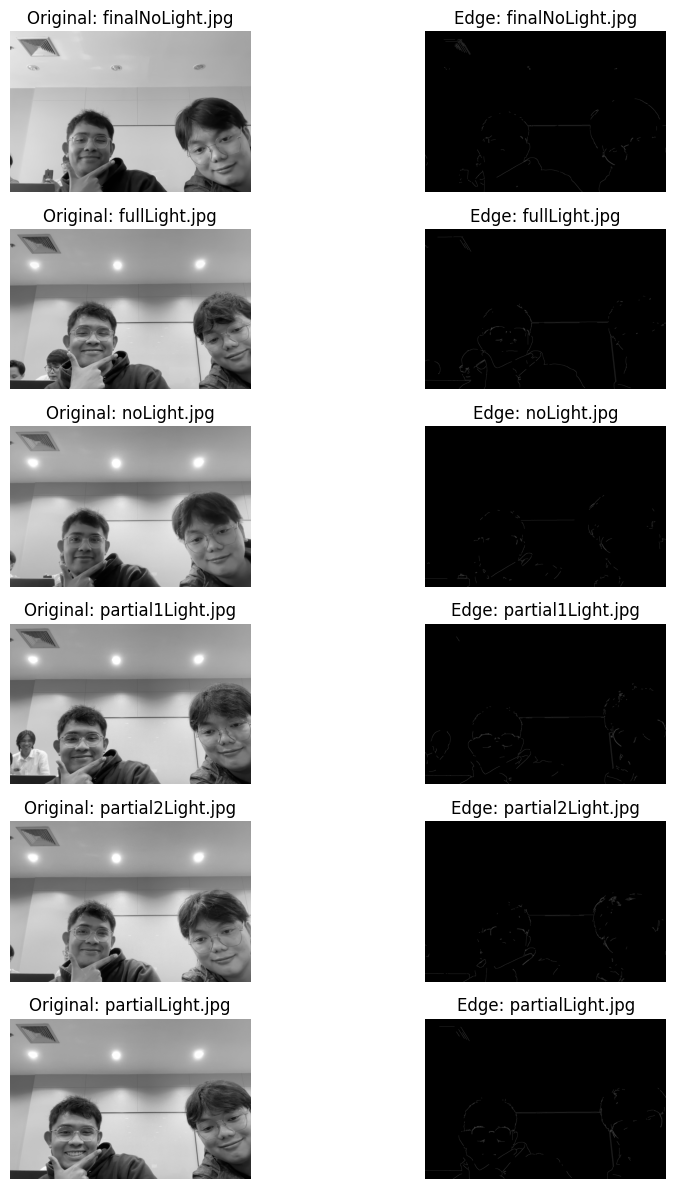

In [4]:
import cv2 as cv
from matplotlib import pyplot as plt

# Read images from the 'pictures' folder
img1 = cv.imread("pictures/finalNoLight.jpg", cv.IMREAD_GRAYSCALE)
img2 = cv.imread("pictures/fullLight.jpg", cv.IMREAD_GRAYSCALE)
img3 = cv.imread("pictures/noLight.jpg", cv.IMREAD_GRAYSCALE)
img4 = cv.imread("pictures/partial1Light.jpg", cv.IMREAD_GRAYSCALE)
img5 = cv.imread("pictures/partial2Light.jpg", cv.IMREAD_GRAYSCALE)
img6 = cv.imread("pictures/partialLight.jpg", cv.IMREAD_GRAYSCALE)

image_list = [img1, img2, img3, img4, img5, img6]
image_names = [
    "finalNoLight.jpg",
    "fullLight.jpg",
    "noLight.jpg",
    "partial1Light.jpg",
    "partial2Light.jpg",
    "partialLight.jpg",
]

plt.figure(figsize=(10, 2 * len(image_list)))
for i, (im, name) in enumerate(zip(image_list, image_names)):
    if im is not None:
        edges = cv.Canny(im, 100, 200)
        plt.subplot(len(image_list), 2, 2 * i + 1)
        plt.imshow(im, cmap="gray")
        plt.title(f"Original: {name}")
        plt.axis("off")
        plt.subplot(len(image_list), 2, 2 * i + 2)
        plt.imshow(edges, cmap="gray")
        plt.title(f"Edge: {name}")
        plt.axis("off")
plt.tight_layout()
plt.show()


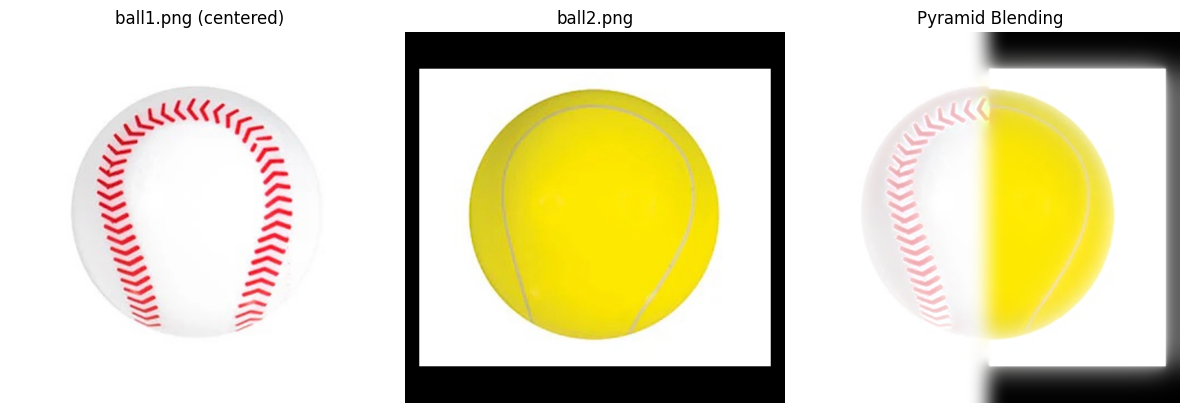

In [6]:
# Read the images
A = cv.imread('ball1.png')
B = cv.imread('ball2.png')
assert A is not None, "file could not be read, check with os.path.exists()"
assert B is not None, "file could not be read, check with os.path.exists()"

# Make both images the same size by centering the smaller one on a canvas of the larger one's size
def center_on_canvas(small, canvas_shape):
    canvas = np.zeros(canvas_shape, dtype=small.dtype)
    y_offset = (canvas_shape[0] - small.shape[0]) // 2
    x_offset = (canvas_shape[1] - small.shape[1]) // 2
    canvas[y_offset:y_offset+small.shape[0], x_offset:x_offset+small.shape[1]] = small
    return canvas

if A.shape != B.shape:
    # Always use the larger shape for the canvas
    target_shape = (
        max(A.shape[0], B.shape[0]),
        max(A.shape[1], B.shape[1]),
        3
    )
    if A.shape != target_shape:
        A = center_on_canvas(A, target_shape)
    if B.shape != target_shape:
        B = center_on_canvas(B, target_shape)

# Generate Gaussian pyramid for A
G = A.copy()
gpA = [G]
for i in range(6):
    G = cv.pyrDown(G)
    gpA.append(G)

# Generate Gaussian pyramid for B
G = B.copy()
gpB = [G]
for i in range(6):
    G = cv.pyrDown(G)
    gpB.append(G)

# Generate Laplacian Pyramid for A
lpA = [gpA[5]]
for i in range(5,0,-1):
    GE = cv.pyrUp(gpA[i], dstsize=(gpA[i-1].shape[1], gpA[i-1].shape[0]))
    L = cv.subtract(gpA[i-1], GE)
    lpA.append(L)

# Generate Laplacian Pyramid for B
lpB = [gpB[5]]
for i in range(5,0,-1):
    GE = cv.pyrUp(gpB[i], dstsize=(gpB[i-1].shape[1], gpB[i-1].shape[0]))
    L = cv.subtract(gpB[i-1], GE)
    lpB.append(L)

# Now add left and right halves of images in each level
LS = []
for la,lb in zip(lpA,lpB):
    rows,cols,dpt = la.shape
    ls = np.hstack((la[:,0:cols//2], lb[:,cols//2:]))
    LS.append(ls)

# Now reconstruct
ls_ = LS[0]
for i in range(1,6):
    ls_ = cv.pyrUp(ls_, dstsize=(LS[i].shape[1], LS[i].shape[0]))
    ls_ = cv.add(ls_, LS[i])

# Image with direct connecting each half
rows,cols,dpt = A.shape
real = np.hstack((A[:,:cols//2],B[:,cols//2:]))

# Save results
cv.imwrite('Pyramid_blending2.jpg',ls_)
cv.imwrite('Direct_blending.jpg',real)

# Display the results
plt.figure(figsize=(12,6))
plt.subplot(1,3,1), plt.imshow(cv.cvtColor(A, cv.COLOR_BGR2RGB)), plt.title('ball1.png (centered)'), plt.axis('off')
plt.subplot(1,3,2), plt.imshow(cv.cvtColor(B, cv.COLOR_BGR2RGB)), plt.title('ball2.png'), plt.axis('off')
plt.subplot(1,3,3), plt.imshow(cv.cvtColor(ls_, cv.COLOR_BGR2RGB)), plt.title('Pyramid Blending'), plt.axis('off')
plt.tight_layout()
plt.show()